<a href="https://colab.research.google.com/github/silprosa/fynesse_mlfc/blob/main/proj/Education.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fynesse Data Analysis Template
## Modern Python Data Science Workflow

This analysis examines education patterns, access, and disparities using the Kenyan National Household Survey data. The study focuses on understanding:

School attendance rates across different demographics

Educational attainment levels

Socio-economic factors affecting education

Infrastructure-related barriers to education

### Setup and installation

In [1]:

%%capture
%pip install osmnx


In [2]:
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import warnings
import numpy as np
import math
import seaborn as sns

import pandas
import numpy
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=FutureWarning, module='osmnx')

import shutil
shutil.rmtree("/content/fynesse_mlfc", ignore_errors=True)

!git clone https://github.com/silprosa/fynesse_mlfc.git
import os, subprocess, importlib, sys
sys.path.append("/content/fynesse_mlfc")
import fynesse
from fynesse import access, assess, address


# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


Cloning into 'fynesse_mlfc'...
remote: Enumerating objects: 505, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 505 (delta 59), reused 8 (delta 8), pack-reused 414 (from 4)
Receiving objects: 100% (505/505), 4.24 MiB | 11.98 MiB/s, done.
Resolving deltas: 100% (277/277), done.


empty the folder if there might be exhisting folders

In [3]:

!git clone https://github.com/silprosa/fynesse_mlfc.git
import os, subprocess, importlib, sys
sys.path.append("/content/fynesse_mlfc")
import fynesse
from fynesse import access, assess, address

fatal: destination path 'fynesse_mlfc' already exists and is not an empty directory.


In [4]:
household = pd.read_stata('/content/drive/MyDrive/knhs/Household_Information_Data.dta')
individual = pd.read_stata('/content/drive/MyDrive/knhs/Individual_Data.dta')

# Data loading and exploration

# **Understanding the data**
The analysis utilizes two main datasets: the Household Information Data and Individual Data from the KNHS. The individual dataset contains detailed information about each household member, including education status, while the household dataset provides contextual information about living conditions and infrastructure.


Individual Dataset: 80,889 individuals across 21,347 households

Household Dataset: 21,347 households with socio-economic data


Sorting data by county and household identifiers

In [5]:
individual = individual.sort_values( by=["a01","interview__key", "hhid__id"],ascending=[True, True,True]).reset_index(drop=True)
individual.head()

,interview__key,interview__id,a01,hhid__id,b02_1,b03,b03_other,b04,b05_years,b05_yrofbirth,...,ken_edu_attendance,edu_attendance,birthplace,relationship_details,mrts_details,age_dep,hhsize,size,wap,age_group
0,00-37-92-54,5D28564B41834855A4F231A1A7Fb8C2D,Mombasa,1,Yes,HEAD,,Male,28,1996.0,...,2 - Not attending,Primary education,1 - Native-born,1 - Reference person / Head,MARRIED /LIVING TOGETHER MONOGAMOUS,15-64,3.0,3-4 persons,1.0,NaN
1,00-37-92-54,5D28564B41834855A4F231A1A7Fb8C2D,Mombasa,2,Yes,WIFE OR HUSBAND,,Female,23,2000.0,...,3 - Not elsewhere classified,Not elsewhere classified,1 - Native-born,2 - Partner / Spouse,MARRIED /LIVING TOGETHER MONOGAMOUS,15-64,3.0,3-4 persons,1.0,NaN
2,00-37-92-54,5D28564B41834855A4F231A1A7Fb8C2D,Mombasa,3,Yes,SON OR DAUGHTER,,Female,3,2020.0,...,3 - Not elsewhere classified,Not elsewhere classified,1 - Native-born,3 - Child / Son / Daughter,NaN,0-14,3.0,3-4 persons,NaN,NaN
3,00-56-58-97,Ff89E29Cd1394E5B91D651085E02B363,Mombasa,1,Yes,HEAD,,Female,65,1959.0,...,3 - Not elsewhere classified,Not elsewhere classified,1 - Native-born,1 - Reference person / Head,WIDOW OR WIDOWER,65 +,3.0,3-4 persons,1.0,NaN
4,00-56-58-97,Ff89E29Cd1394E5B91D651085E02B363,Mombasa,2,Yes,GRANDCHILD,,Male,20,2003.0,...,2 - Not attending,Secondary Education,1 - Native-born,4 - Grandchild / Grandson / Granddaughter,NEVER MARRIED,15-64,3.0,3-4 persons,1.0,NaN


In [6]:
household = household.sort_values(by=["a01","interview__key"], ascending=[True, True] ).reset_index(drop=True)
household.iloc[21107:21110,20:100]

,c02_5,c03,c03_other,c04,c04other,c05,c06,c07,c07_1,c08,...,d20__2,d20__3,d20__4,d20__5,d20__6,d20__7,d20__8,d20__9,d20__10,e01
21107,Household member,Delay in connection,,Pit latrine with slab,,Yes,4.0,No,,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
21108,NaN,NaN,,Flush to Piped Sewer System,,No,NaN,"Yes, Soap/detergent and Water",,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
21109,NaN,NaN,,Flush to Septic tank,,No,NaN,"Yes, Soap/detergent and Water",,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Yes, elsewhere"


Identifying missing values

In [7]:
nan_count = household.isna().sum().to_frame().T
display(nan_count)

,interview__key,interview__id,a01,countycode,a07_1,serial,a12,c01_1,c01_1other,c01_2,...,med_prop,med_brms,hhweight,tag,internet,year_occ,pln,sf,duration,bf
0,0,0,0,0,0,0,0,0,0,0,...,15088,16670,0,0,14376,14402,17767,20785,14542,18956


In [8]:
df  = individual.copy()
heads_in_hh1 = df[(df["hhid__id"] == 1) & (df["b03"] == "HEAD")]

count_heads = heads_in_hh1.shape[0]
heads = df[df["b03"] == "HEAD"]
print("Number of heads in household 1:", count_heads)
print("Total number of heads:", heads.shape[0])


Number of heads in household 1: 20977
Total number of heads: 21286


We create a copy of the original DataFrame individual and store it as individuals to preserve the raw dataset. In this copy, we rename several columns to more descriptive names for easier interpretation and analysis.i.e b05_years to age, so that the dataset is more readable.

In [9]:
individuals = individual.copy()
individuals.rename(
    columns={
        "interview__key": "interview_key",
        "interview__id": "interview_id",
        "a01": "county",
        "b03": "relationship_to_head",
        "hhid__id": "hh_id",
        "b04": "gender",
        "b05_years": "age",
        "b05_yrofbirth": "yrofbirth",
        "b10": "ever_schooled",
        "b11": "currently_schooling",
        "b12": "current_level",
        "b13": "highest_level",
        "edu_attendance": "education_level",
        "b13_1": "distance_to_school",
        "b13_2": "mode_transport_to_school",
        "b13_3": "time_to_school",
        "b13_4": "cost_to_school"
    },
    inplace=True
)

individuals.iloc[:,9:20]

,yrofbirth,b05_monthofbirth,b05_day,age_cur,b06,b07,b08_1,b08_2,b08_3,b08_4,b08_5
0,1996.0,FEBRUARY,22.0,28.0,MARRIED /LIVING TOGETHER MONOGAMOUS,PROTESTANT,No - no difficulty,No - no difficulty,No - no difficulty,No - no difficulty,No - no difficulty
1,2000.0,AUGUST,4.0,23.0,MARRIED /LIVING TOGETHER MONOGAMOUS,PROTESTANT,No - no difficulty,No - no difficulty,No - no difficulty,No - no difficulty,No - no difficulty
2,2020.0,MARCH,17.0,3.0,NaN,PROTESTANT,No - no difficulty,No - no difficulty,No - no difficulty,No - no difficulty,No - no difficulty
3,1959.0,JANUARY,1.0,65.0,WIDOW OR WIDOWER,EVANGELICAL CHURCHES,No - no difficulty,No - no difficulty,Cannot do at all,Yes - some difficulty,No - no difficulty
4,2003.0,NOVEMBER,22.0,20.0,NEVER MARRIED,EVANGELICAL CHURCHES,No - no difficulty,No - no difficulty,No - no difficulty,No - no difficulty,No - no difficulty
...,...,...,...,...,...,...,...,...,...,...,...
80884,1984.0,MARCH,12.0,40.0,NEVER MARRIED,CATHOLIC,No - no difficulty,No - no difficulty,No - no difficulty,No - no difficulty,No - no difficulty
80885,1991.0,NOVEMBER,24.0,32.0,MARRIED /LIVING TOGETHER MONOGAMOUS,PROTESTANT,No - no difficulty,No - no difficulty,No - no difficulty,No - no difficulty,No - no difficulty
80886,1996.0,FEBRUARY,1.0,28.0,MARRIED /LIVING TOGETHER MONOGAMOUS,PROTESTANT,No - no difficulty,No - no difficulty,No - no difficulty,No - no difficulty,No - no difficulty
80887,2016.0,JULY,30.0,7.0,NaN,PROTESTANT,No - no difficulty,No - no difficulty,No - no difficulty,No - no difficulty,No - no difficulty


do the same for households

In [10]:
households = household.copy()
households.rename(
    columns={
        "interview__key": "interview_key",
        "interview__id": "interview_id",
        "a01": "county",
         "a07_1": "rural_urban",

        "c01_1": "water_source",
        "c04": "toilet_type",
        "c08": "has_electricity",
        "c13__1": "fixed_internet",
        "c13__2": "mobile_internet",
        "e06": "flooding",

        "g01a": "dist_pri_school",
        "g01b": "dist_sec_school",
        "g02": "units",
        "g04": "has_street_lights",
        "k05": "monthly_rent",
        "k08_1": "rent_increased",
        "K08_2": "no_rent_increase",
        "K08_3": "by_how_much",
        "114": "dwelling_value"

    },
    inplace=True
)


In [11]:
households.iloc[:,4:14]

,rural_urban,serial,a12,water_source,c01_1other,c01_2,c01_2other,c01_3,c01_4,c01_5
0,Urban,87673392,3,PUBLIC WATER COMPANIES,,PUBLIC TAP/STANDPIPE,,Yes,60.0,Household member
1,Urban,75225784,3,PRIVATE WATER COMPANIES,,FETCHED BY HOUSEHOLD,,No,5.0,Household member
2,Urban,77076112,2,PRIVATE WATER COMPANIES,,FETCHED BY HOUSEHOLD,,No,2.0,Household member
3,Urban,74711296,5,PUBLIC WATER COMPANIES,,PIPED TO NEIGHBOR,,No,15.0,Household member
4,Urban,77137000,1,TUBE WELL OR BOREHOLE (Community),,DELIVERED BY A WATER VENDOR,,Yes,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
21342,Urban,48808572,4,PUBLIC WATER COMPANIES,,PIPED INTO DWELLING,,Yes,NaN,NaN
21343,Urban,91886632,3,PUBLIC WATER COMPANIES,,PIPED TO YARD/PLOT,,Yes,NaN,NaN
21344,Urban,86378128,3,TUBE WELL OR BOREHOLE (Community),,FETCHED BY HOUSEHOLD,,Yes,5.0,Household member
21345,Urban,38476688,8,PUBLIC WATER COMPANIES,,PIPED INTO DWELLING,,Yes,NaN,NaN


In [12]:
households['water_source'].value_counts(dropna=False)

,count
water_source,
PUBLIC WATER COMPANIES,5729
SURFACE WATER (RIVER/DAM/LAKE/POND/STREAM/CANAL/IRRIGATION CHANNEL),3854
TUBE WELL OR BOREHOLE (Community),2609
RAINWATER,1951
PRIVATE WATER COMPANIES,1546
TUBE WELL OR BOREHOLE (Owned),1477
WATER FROM SPRING (Protected),1294
DUG WELL (Protected),1065
PACKAGED BOTTLED WATER,688


The education-related variables of focus include school attendance status, current education level, highest education attained, distance to school, transportation modes

In [13]:
pd_subset = households[["dist_pri_school", "dist_sec_school", "units"]]
print(pd_subset)


       dist_pri_school  dist_sec_school           units
0               2000.0           5000.0       Meters(M)
1                 50.0           5000.0  Kilometers(KM)
2                500.0            700.0       Meters(M)
3                200.0            200.0       Meters(M)
4               2000.0           3000.0       Meters(M)
...                ...              ...             ...
21342            330.0             10.0       Meters(M)
21343            200.0            250.0       Meters(M)
21344            130.0            210.0       Meters(M)
21345           5000.0           5000.0       Meters(M)
21346            200.0            500.0       Meters(M)

[21347 rows x 3 columns]


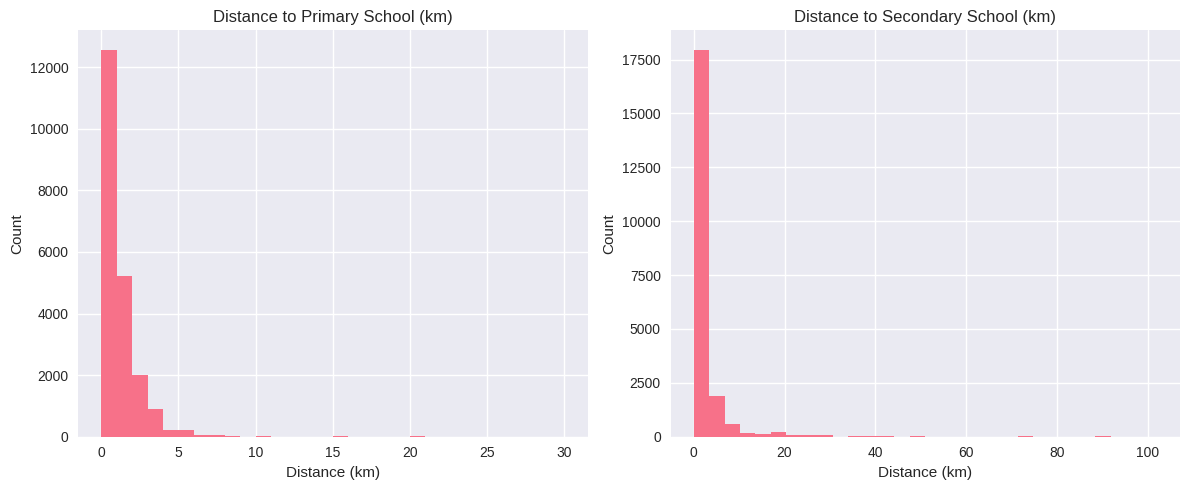

In [14]:
plt.figure(figsize=(12,5))

# Convert to km before plotting
was = households["dist_pri_school"] / 1000
plt.subplot(1,2,1)
was.dropna().hist(bins=30)
plt.title("Distance to Primary School (km)")
plt.xlabel("Distance (km)")
plt.ylabel("Count")

will = households["dist_sec_school"] / 1000
plt.subplot(1,2,2)
will.dropna().hist(bins=30)
plt.title("Distance to Secondary School (km)")
plt.xlabel("Distance (km)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()



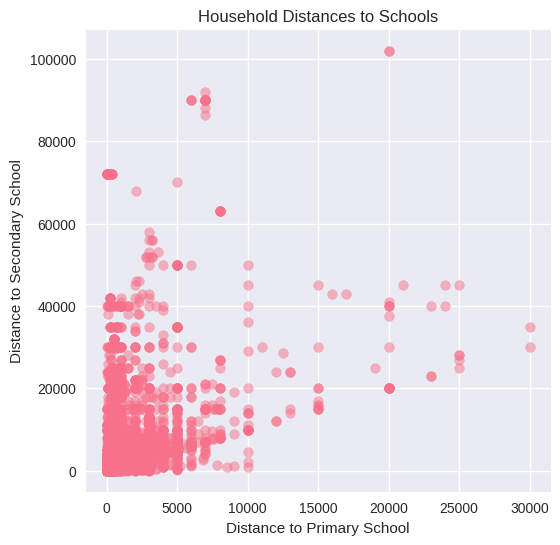

In [15]:
plt.figure(figsize=(6,6))
plt.scatter(
    households["dist_pri_school"],
    households["dist_sec_school"],
    alpha=0.5
)
plt.xlabel("Distance to Primary School")
plt.ylabel("Distance to Secondary School")
plt.title("Household Distances to Schools")
plt.show()


/tmp/ipython-input-2639567277.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  households.groupby("county")[["dist_pri_school", "dist_sec_school"]]


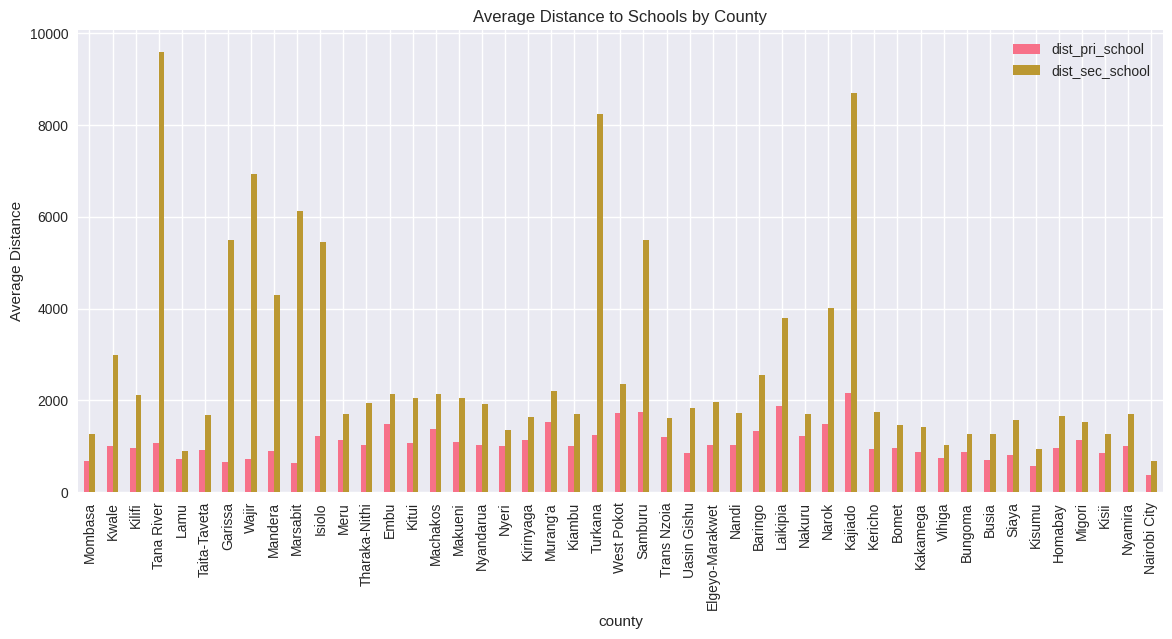

In [16]:
county_distances = (
    households.groupby("county")[["dist_pri_school", "dist_sec_school"]]
    .mean()
    .reset_index()
)

county_distances.plot(
    x="county",
    kind="bar",
    figsize=(14,6)
)
plt.ylabel("Average Distance")
plt.title("Average Distance to Schools by County")
plt.xticks(rotation=90)
plt.show()


I created a relation table to show the level of education

In [17]:
education_map = access.education_mapping

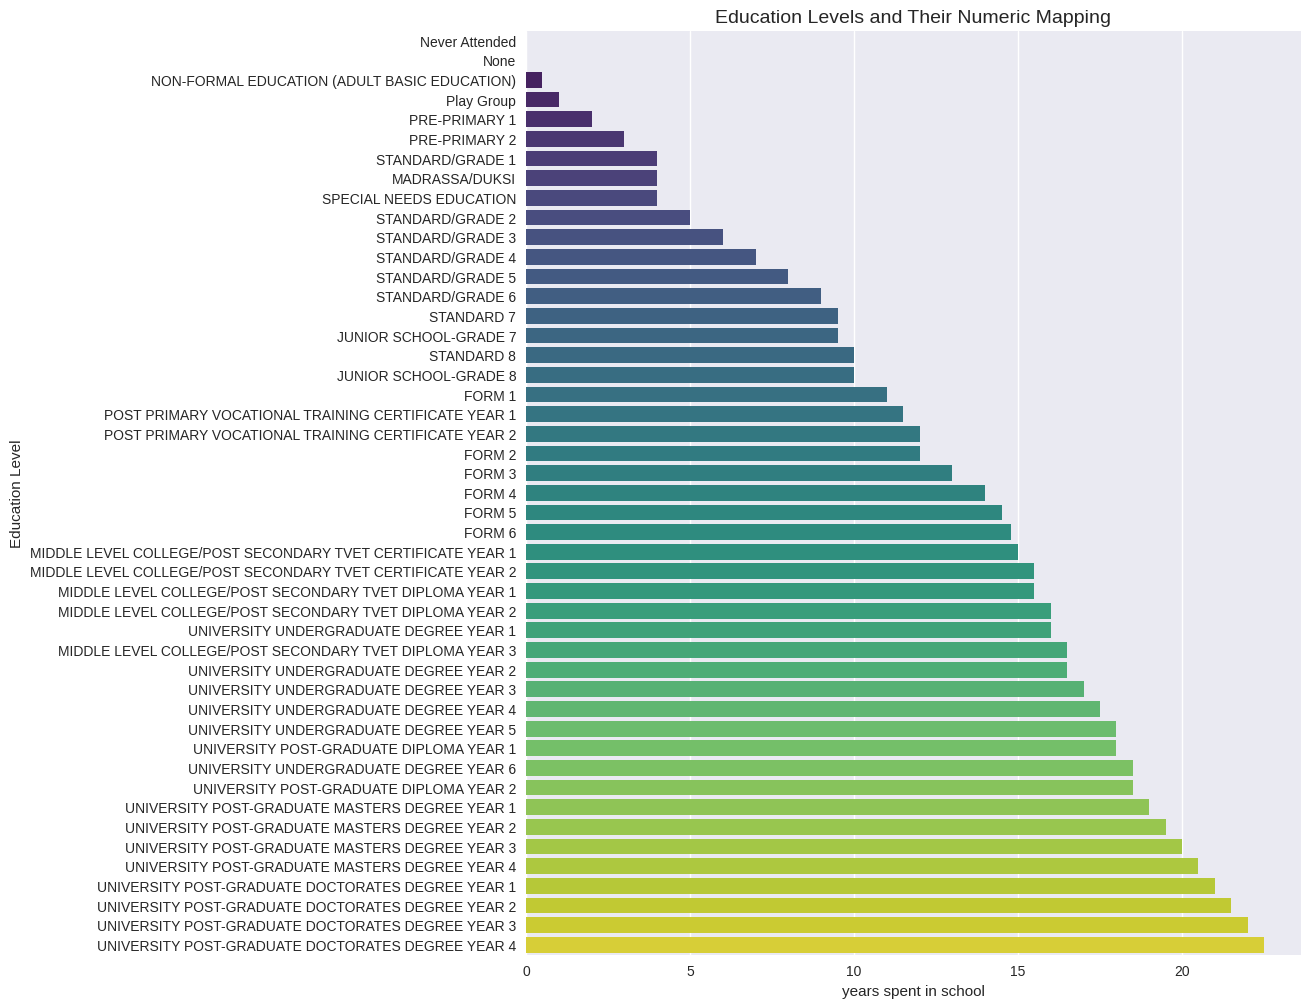

In [18]:

edu_df = pd.DataFrame(list(education_map.items()), columns=["education_level", "mapped_value"])

edu_df = edu_df.sort_values("mapped_value")
plt.figure(figsize=(10, 12))
sns.barplot(x='mapped_value', y='education_level', hue='education_level', data=edu_df, palette='viridis',legend=False)
plt.title("Education Levels and Their Numeric Mapping", fontsize=14)
plt.xlabel("years spent in school")
plt.ylabel("Education Level")
plt.show()


In [19]:
simple_education_map = access.easy_education_mapping


Assess



In [20]:
counties = individuals['county'].unique()

we first clean and standardize county names from the dataset

In [21]:
county_list =access.clean_county_names(counties)
print(county_list)

['Mombasa', 'Kwale', 'Kilifi', 'Tana River', 'Lamu', 'Taita-Taveta', 'Garissa', 'Wajir', 'Mandera', 'Marsabit', 'Isiolo', 'Meru', 'Tharaka-Nithi', 'Embu', 'Kitui', 'Machakos', 'Makueni', 'Nyandarua', 'Nyeri', 'Kirinyaga', 'Muranga', 'Kiambu', 'Turkana', 'West Pokot', 'Samburu', 'Trans Nzoia', 'Uasin Gishu', 'Elgeyo-Marakwet', 'Nandi', 'Baringo', 'Laikipia', 'Nakuru', 'Narok', 'Kajiado', 'Kericho', 'Bomet', 'Kakamega', 'Vihiga', 'Bungoma', 'Busia', 'Siaya', 'Kisumu', 'Homabay', 'Migori', 'Kisii', 'Nyamira', 'Nairobi']


We then retrieve the corresponding OpenStreetMap relation IDs for each county through the get_relation_ids function, which converts administrative names into machine-readable identifiers that can be used for spatial operations.

In [22]:
relation_ids = access.get_relation_ids(county_list)
print(relation_ids)

['R3495554', 'R3495548', 'R3495545', 'R3495561', 'R3495550', 'R3495560', 'R3495541', 'R3495566', 'R3495551', 'R3495552', 'R3495542', 'R3495553', 'R3495562', 'R3495540', 'R3495547', 'r3492707', 'r3492708', 'r3495557', 'r3495558', 'r3495546', 'r3977580', 'r3495544', 'R3495564', 'r11981571', 'r3495559', 'r3495563', 'r3495565', 'R11981582', 'R3495556', 'r3495537', 'r3495549', 'r14649082', 'r3338145', 'r3486020', 'r3486288', 'R14649074', 'r3495543', 'r3486322', 'r3495538', 'r3486321', 'r3486291', 'r3486289', 'r3486017', 'r3486018', 'r3338140', 'r3486290', 'R3492709']


 I created a fuction to plot a  map ussing realtion ids for geographical context, we will use it to show our education analysis by showing the geographical distribution of our data across different regions of Kenya

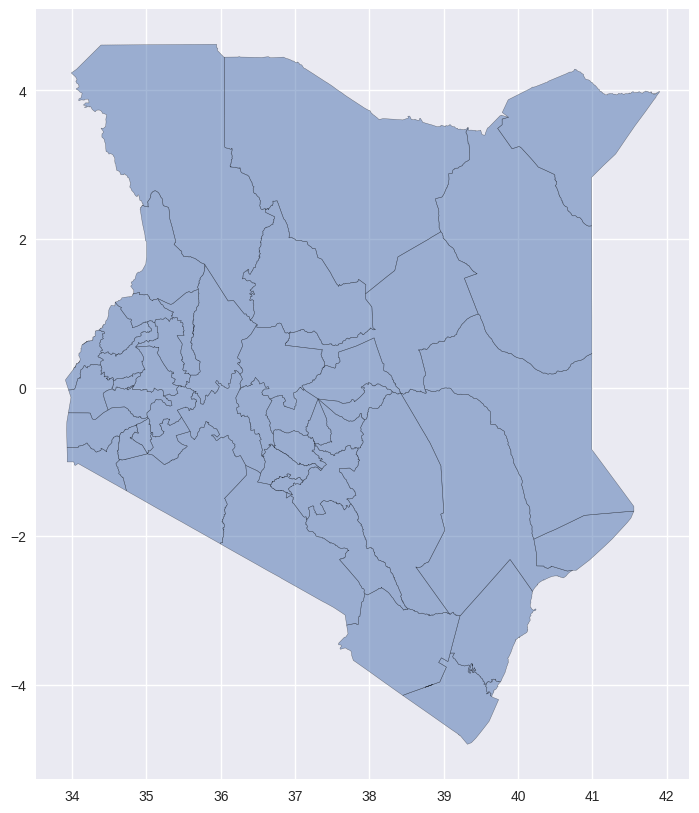

In [23]:
gdf = access.plot_counties(relation_ids)


In [24]:
individuals['ever_schooled'].value_counts()

,count
ever_schooled,
Yes,63869
No,11286


In [25]:
person  = individuals.copy()
person['ever_schooled'].isna().sum()



np.int64(5734)

In [26]:
person  =person.dropna(subset=['ever_schooled'])
person['ever_schooled'].isna().sum()

np.int64(0)

I created a function which converts variables which are similar to boolean and makes them boolean

In [27]:
person = access.clean_boolean_columns(individuals, columns=["ever_schooled"])
person['ever_schooled'].value_counts()


,count
ever_schooled,
True,63869
False,11286


In [28]:
dist = person.groupby(['county', 'ever_schooled'], observed=True).size().reset_index(name='count')


visualised Distribution of School Attendance Across Counties

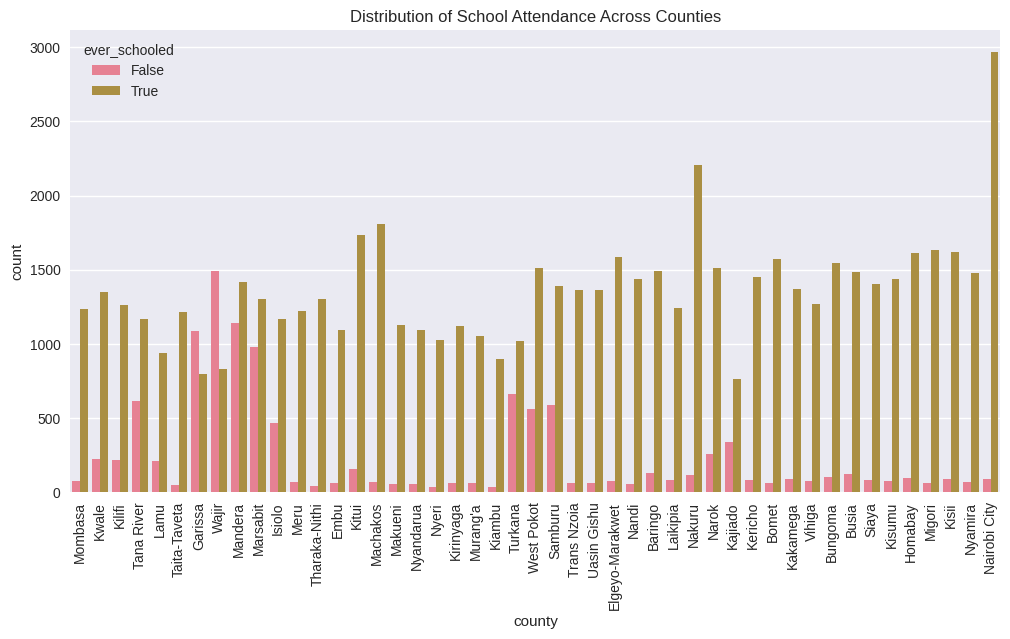

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(data=dist, x='county', y='count', hue='ever_schooled')
plt.xticks(rotation=90)
plt.title("Distribution of School Attendance Across Counties")
plt.show()

the generated choropleth map visualizes the geographical distribution of educational access across Kenyan counties,i.e shows the average proportion of individuals who have ever attended school in each region.

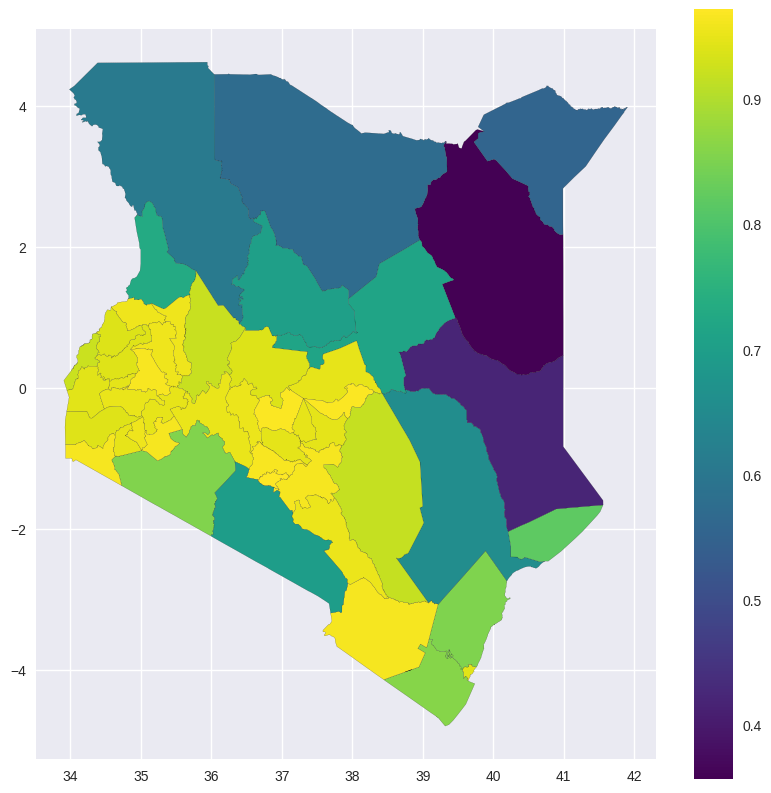

In [30]:
mean_schooled = person.groupby('county',observed=False )['ever_schooled'].mean().reset_index(name='mean_prop_schooled')
prop = mean_schooled['mean_prop_schooled'].astype(float)
access.plot_counties(relation_ids, prop)

#plot_counties(relation_ids, prop)

# internet access



In [31]:

households['internet'].value_counts(dropna=False)



,count
internet,
NaN,14376
1.0,6971


# below is experimental

Age Distribution of School-Age Population

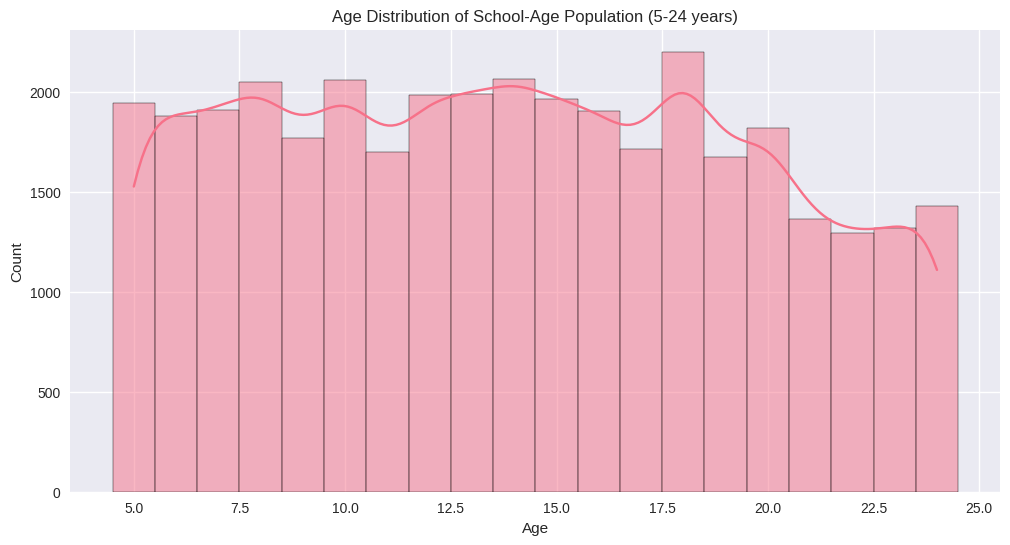

In [32]:
def plot_age_distribution():
    plt.figure(figsize=(12, 6))
    school_age = individuals[(individuals['age'] >= 5) & (individuals['age'] <= 24)]
    sns.histplot(school_age['age'].dropna(), bins=20, kde=True)
    plt.title('Age Distribution of School-Age Population (5-24 years)')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.show()
    return
plot_age_distribution()

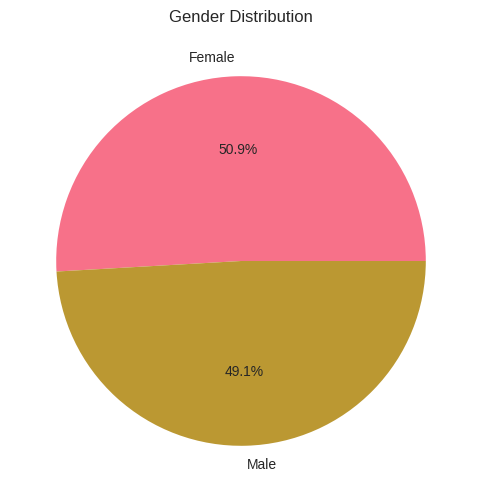

In [33]:
def plot_gender_distribution():
    plt.figure(figsize=(8, 6))
    gender_counts = individuals['gender'].value_counts()
    plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%')
    plt.title('Gender Distribution')
    plt.show()
plot_gender_distribution()

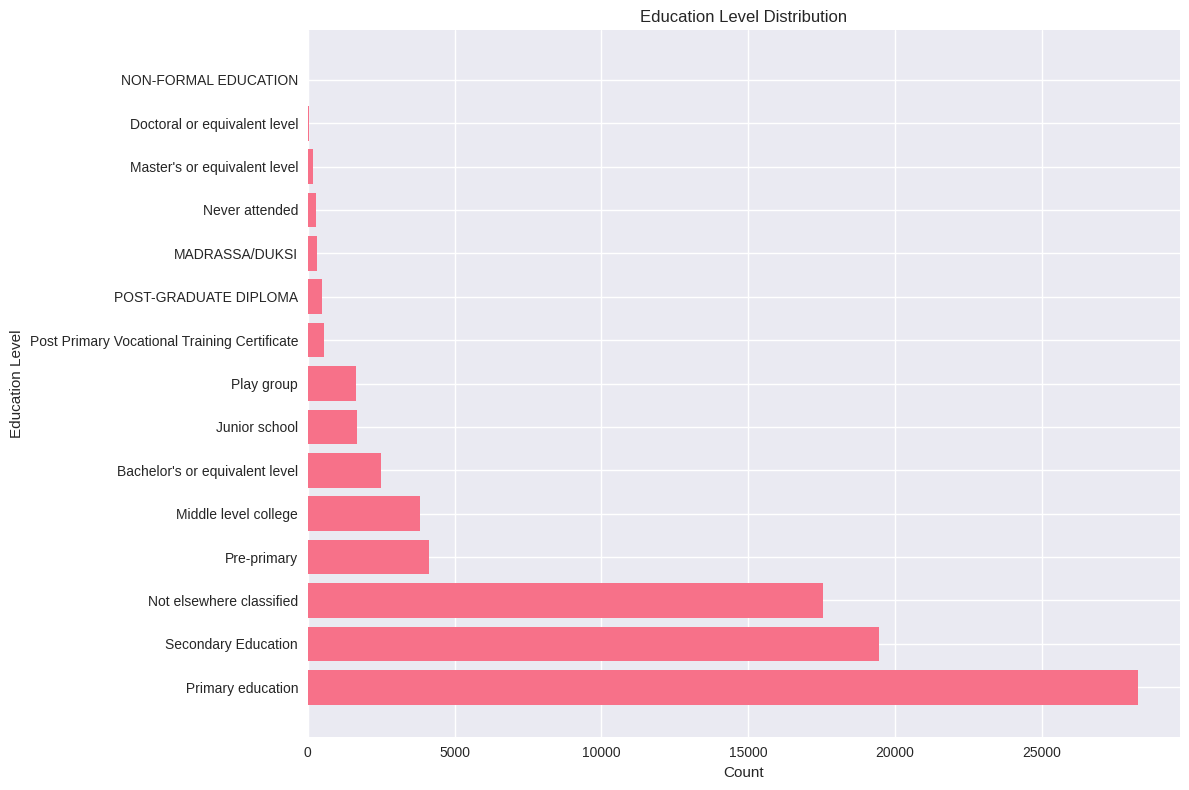

In [34]:
def plot_education_levels():
    plt.figure(figsize=(12, 8))
    education_levels = individuals['education_level'].value_counts().dropna()
    plt.barh(education_levels.index, education_levels.values)
    plt.title('Education Level Distribution')
    plt.xlabel('Count')
    plt.ylabel('Education Level')
    plt.tight_layout()
    plt.show()
plot_education_levels()

In [35]:
def analyze_distance_to_school():
    return

/tmp/ipython-input-2703887502.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  households.groupby("county")[["dist_pri_school", "dist_sec_school"]]


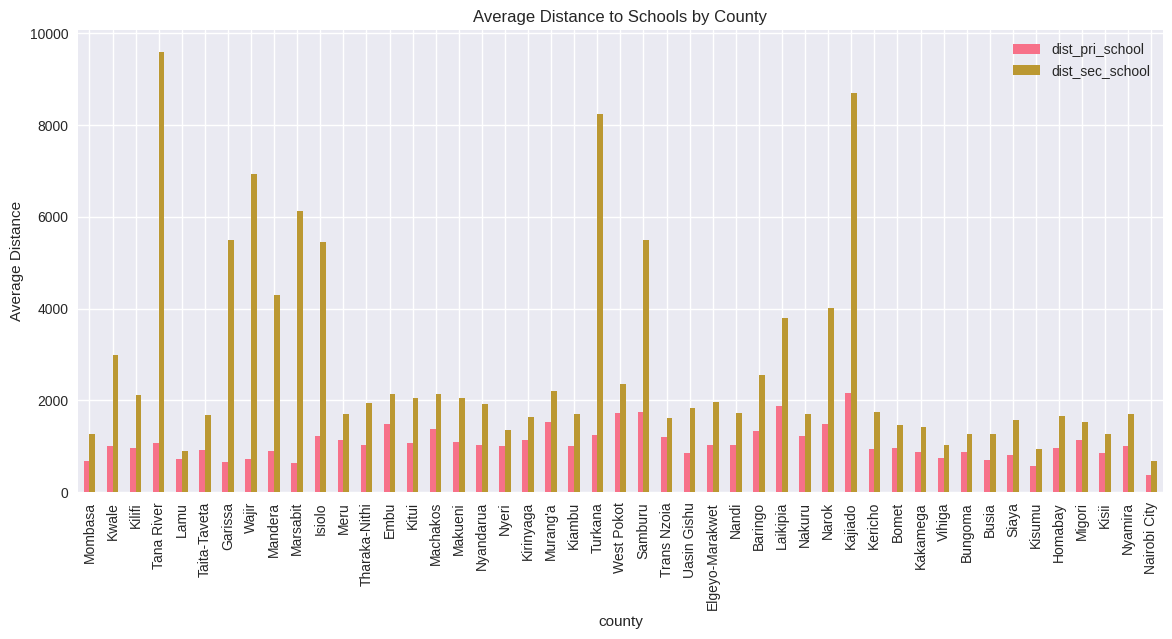

In [38]:
county_distances = (
    households.groupby("county")[["dist_pri_school", "dist_sec_school"]]
    .mean()
    .reset_index()
)

county_distances.plot(
    x="county",
    kind="bar",
    figsize=(14,6)
)
plt.ylabel("Average Distance")
plt.title("Average Distance to Schools by County")
plt.xticks(rotation=90)
plt.show()

In [36]:
area = pd.read_csv("/content/drive/MyDrive/area.gsheet")

OSError: [Errno 95] Operation not supported: '/content/drive/MyDrive/area.gsheet'